In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats

In [2]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[(dt2.Date.dt.year > 2010) & (dt2.Date.dt.year < 2017)]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[(dt1.DATE.dt.year > 2010) & (dt1.DATE.dt.year < 2017)]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)
wte['WTD'] = -(422.0 - wte.WTE)

In [3]:
'''Functions'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

def fdc(ax, timeseries, kwargs = None):
    """
    #From Flow-Duration-Curve by florianjehn
    Plots a single fdc into an ax.
    
    :param ax: matplotlib subplot object
    :param timeseries: list like iterable
    :param kwargs: dict, keyword arguments for matplotlib

    return: subplot object with a flow duration curve drawn into it
    """
    # Get the probability
    exceedence = np.arange(1., len(timeseries) + 1) / len(timeseries)
    exceedence *= 100
    # Plot the curve, check for empty kwargs
    if kwargs is not None:
        ax.plot(exceedence, sorted(timeseries, reverse=True), **kwargs)
    else:
        ax.plot(exceedence, sorted(timeseries, reverse=True))
    return ax

def cor_plot(ax, meas, mod, c, title, stream = True):
    ax.scatter(meas, mod, color = c, alpha = 0.5)
    ax.axline([0,0], slope = 1, color = 'silver', zorder = -2)
    
    if(stream):
        ax.set_xlim(0, 5e-4)
        ax.set_ylim(0, 5e-4)

        nse_plot = nse(mod, meas)
        ax.text(1.5e-4, 5e-5, r'$NSE$: ' + str(round(nse_plot, 2)))
        r2_plot = rsquared(meas, mod)
        res = spearman(meas, mod)
        ax.text(1.5e-4, 1e-4, r'$R^2$: ' + str(round(r2_plot, 2)) + r' $R_{spear}$: ' + str(round(res, 2)))
    else:
        ax.set_xlim(-1, 0.2)
        ax.set_ylim(-1, 0.2)

        r2_plot = rsquared(meas, mod)
        res = spearman(meas, mod)
        ax.text(-0.95, 0.05, r'$R^2$: ' + str(round(r2_plot, 2)) + r' $R_{spear}$: ' + str(round(res, 2)))
        
    ax.set_title(title, fontsize='small', loc='left')
    
    return ax

In [6]:
'''Read in data'''
#Uncalibrated data
SPRUCEuncalib = xr.open_mfdataset('ELM-SPRUCE/initRUN/TEST_US-SPR_ICB20TRCNPRDCTCBC/run/TEST_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMuncalib = xr.open_mfdataset('CLM5/derecho-nocalib/derecho_base_nocalib.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-nocalib/test-derecho-nuopc.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalibcol = xr.open_mfdataset('CLM-hillslope/3col-derecho-nocalib/test-derecho-nuopc.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Calibrated Data
SPRUCEcalib = xr.open_mfdataset('ELM-SPRUCE/shiPARAMS/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMcalib = xr.open_mfdataset('CLM5/derecho-streamcalib-oldspinup/derecho_stream_calib.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-onlypftcalib/hillslope-bayes-opt.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalibcol =  xr.open_mfdataset('CLM-hillslope/3col-derecho-onlypftcalib/hillslope-bayes-opt.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Fenghui data
FenghuiData = xr.open_mfdataset('ELM-SPRUCE/fenghui/T0.00_US-SPR_I20TRCLM45CN.clm2.h0.*-01-01-00000.nc', 
                                parallel = True)


In [8]:
'''Subset Timestamps'''
SPRUCEuncalib = SPRUCEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
CLMuncalib = CLMuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalib = HILLSLOPEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalibcol = HILLSLOPEuncalibcol.sel(time = slice("2011-01-01", "2016-12-31"))

SPRUCEcalib = SPRUCEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalib = HILLSLOPEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalibcol = HILLSLOPEcalibcol.sel(time = slice("2011-01-01", "2016-12-31"))
CLMcalib = CLMcalib.sel(time = slice("2011-01-04", "2016-12-31"))

fenghui = FenghuiData.sel(time = slice("2014-01-01", "2016-12-31"))

In [9]:
'''Plotting Specifics'''
#Colors
pal = sns.color_palette('Set2')
sns.color_palette("Set2")
#Use 0 - Spruce Hummock
#    2 - Spruce Hollow
#    1 - CLM 5.0
#    3 - CLM Hillslope

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

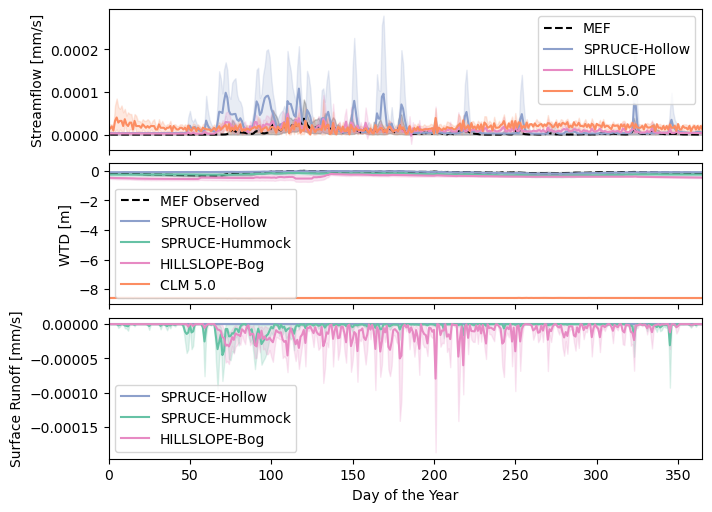

In [10]:
### Plot 1 - Stacked Q, WTE, and Lateral Flow plot
fig, ax = plt.subplots(3, 1, figsize = (7, 5), 
                       sharex = True, 
                       constrained_layout = True)

#Top Axis: Streamflow
sns.lineplot(x = stream.Date.dt.dayofyear, y = stream['Flow_mms'],
             color = 'black', linestyle = '--', label = 'MEF', ax = ax[0])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = SPRUCEcalib.sel(lndgrid = 1).QRUNOFF,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax[0])
sns.lineplot(x = HILLSLOPEcalib.time.dt.dayofyear, y = np.array(HILLSLOPEcalib.QRUNOFF).reshape(2190),
             label = 'HILLSLOPE', color = pal[3], ax = ax[0])
sns.lineplot(x = CLMcalib.time.dt.dayofyear, y = np.array(CLMcalib.QRUNOFF).reshape(2187),
             label = 'CLM 5.0', color = pal[1], ax = ax[0])
ax[0].set_ylabel('Streamflow [mm/s]')

#Middle Axis: Water table elevation in the Bog
sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF Observed', ax = ax[1])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax[1])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax[1])
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEcalibcol.sel(column = 1).ZWT).reshape(2190),
             label = 'HILLSLOPE-Bog', color = pal[3], ax = ax[1])
sns.lineplot(x = CLMcalib.time.dt.dayofyear, y = -np.array(CLMcalib.ZWT).reshape(2187),
             label = 'CLM 5.0', color = pal[1], ax = ax[1])
ax[1].set_ylabel('WTD [m]')

#Bottom Axis: Lateral flow out of the Bog in to the Lagg
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).QOVER,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax[2])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).QOVER,
             label = 'SPRUCE-Hummock', color = pal[0],  ax = ax[2])
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEcalibcol.sel(column = 1).QOVER).reshape(2190),
             label = 'HILLSLOPE-Bog', color = pal[3], ax = ax[2])
ax[2].set_ylabel('Surface Runoff [mm/s]')


plt.xlabel('Day of the Year')
plt.xlim(0, 365)
plt.savefig('./figures/AGU/timeseries.pdf', bbox_inches = 'tight')
plt.savefig('./figures/AGU/timeseries.svg', bbox_inches = 'tight')

Text(0.5, 0, 'Day of the Year')

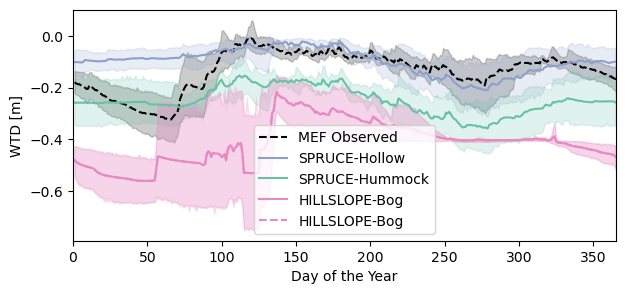

In [11]:
#Plot 1.5: Water Table Dynamics up close
fig, ax = plt.subplots(1, 1, figsize = (7, 3))

sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF Observed', ax = ax)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax)
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEcalibcol.sel(column = 1).ZWT).reshape(2190),
             label = 'HILLSLOPE-Bog', color = pal[3], ax = ax)
sns.lineplot(x = HILLSLOPEuncalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEuncalibcol.sel(column = 1).ZWT).reshape(2190),
             label = 'HILLSLOPE-Bog', linestyle = '--', color = pal[3], ax = ax)

ax.set_xlim(0, 365)
ax.set_ylabel('WTD [m]')
ax.set_xlabel('Day of the Year')

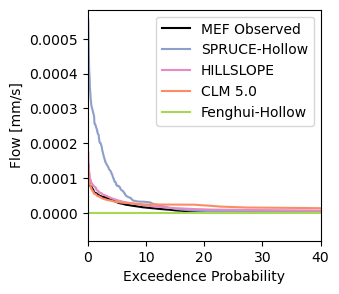

In [64]:
#Plot 2 Streamflow Duration Curves for 2011-2017

fig, ax = plt.subplots(1, 1, figsize = (3, 3))

fdc(ax, stream['Flow_mms'], kwargs = {"color":'black', "label":'MEF Observed'}) #Marcell Data
fdc(ax, SPRUCEcalib.sel(lndgrid = 1).QRUNOFF, kwargs = {"label":'SPRUCE-Hollow', "color":pal[2]}) #SPRUCE Data
fdc(ax, HILLSLOPEuncalib.QRUNOFF, kwargs = {"label":'HILLSLOPE', "color":pal[3]}) #Hillslope Data
fdc(ax, CLMuncalib.QRUNOFF, kwargs = {"label":'CLM 5.0', "color":pal[1]}) #Hillslope Data
fdc(ax, fenghui.sel(lndgrid = 1).QRUNOFF, kwargs = {"label":'Fenghui-Hollow', "color":pal[4]}) #Hillslope Data
ax.legend(bbox_to_anchor = (1,1))
ax.set_xlim(0, 40)
ax.set_xlabel('Exceedence Probability')
ax.set_ylabel('Flow [mm/s]')

plt.savefig('./figures/AGU/FDC.pdf', bbox_inches = 'tight')
plt.savefig('./figures/AGU/FDC.svg', bbox_inches = 'tight')

/glade/derecho/scratch/marielj/tmp/ipykernel_45689/2218034863.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2,0].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
/glade/derecho/scratch/marielj/tmp/ipykernel_45689/2218034863.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2,1].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)


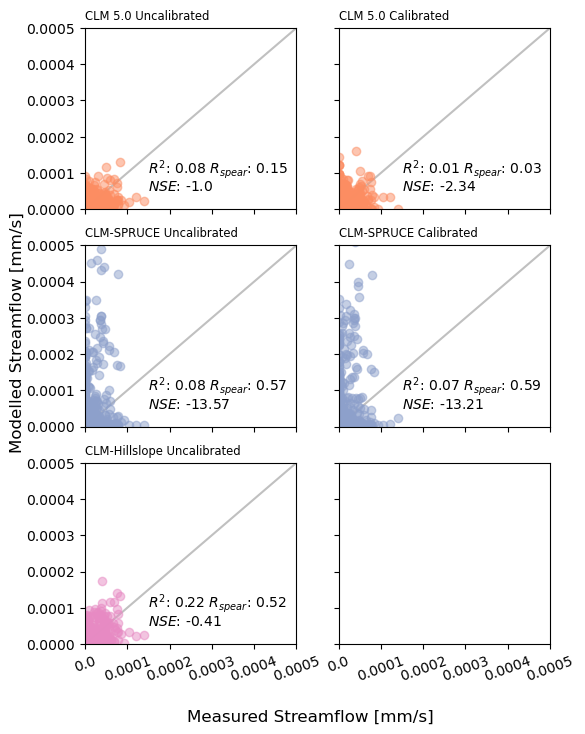

In [50]:
#Plot 3 Model R2 and NSE for Streamflow and WTE
#Remove leap days from MEF data
obsQ = stream[~((stream['Date'].dt.month == 2) &(stream['Date'].dt.day == 29))]['Flow_mms']

fig, ax = plt.subplots(3, 2, figsize = (6, 8), 
                      sharex = True,
                      sharey = True)
#CLM 5.0
cor_plot(ax[0, 0], obsQ, np.array(CLMuncalib.QRUNOFF).reshape(2190), pal[1], 'CLM 5.0 Uncalibrated')
cor_plot(ax[0, 1], obsQ[3:], np.array(CLMcalib.QRUNOFF).reshape(2187), pal[1], 'CLM 5.0 Calibrated')
#CLM-SPRUCE
cor_plot(ax[1, 0], obsQ, np.array(SPRUCEuncalib.isel(lndgrid = 1).QRUNOFF).reshape(2190), pal[2], 'CLM-SPRUCE Uncalibrated')
cor_plot(ax[1, 1], obsQ, np.array(SPRUCEcalib.isel(lndgrid = 1).QRUNOFF).reshape(2190), pal[2], 'CLM-SPRUCE Calibrated')
#CLM-HILLSLOPE
cor_plot(ax[2, 0], obsQ, np.array(HILLSLOPEuncalib.QRUNOFF).reshape(2190), pal[3], 'CLM-Hillslope Uncalibrated')
#cor_plot(ax[2, 1], obsQ, np.array(HILLSLOPEcalib.QRUNOFF).reshape(2190), pal[3], 'CLM-Hillslope Calibrated')

ax[2,0].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
ax[2,1].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
fig.supxlabel('Measured Streamflow [mm/s]')
fig.supylabel('Modelled Streamflow [mm/s]', x = 0)

plt.savefig('./figures/AGU/streamflowCorrelations.pdf', bbox_inches = 'tight')
plt.savefig('./figures/AGU/streamflowCorrelations.svg', bbox_inches = 'tight')

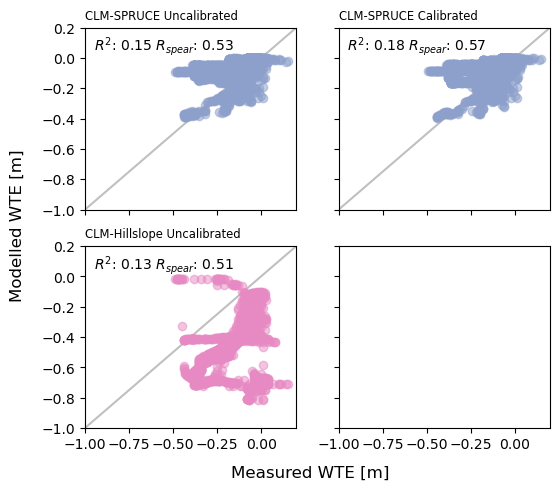

In [62]:
#Plot 4 Model R2 and NSE for WTE
#Remove leap days from MEF data
obsWTE = wte[~((wte['DATE'].dt.month == 2) &(wte['DATE'].dt.day == 29))]['WTD']

fig, ax = plt.subplots(2, 2, figsize = (6, 5.2), 
                      sharex = True,
                      sharey = True)

#CLM-SPRUCE
cor_plot(ax[0, 0], obsWTE, -np.array(SPRUCEuncalib.isel(lndgrid = 1).ZWT).reshape(2190), pal[2], 'CLM-SPRUCE Uncalibrated', stream = False)
cor_plot(ax[0, 1], obsWTE, -np.array(SPRUCEcalib.isel(lndgrid = 1).ZWT).reshape(2190), pal[2], 'CLM-SPRUCE Calibrated', stream = False)

#CLM-HILLSLOPE - BOG
cor_plot(ax[1, 0], obsWTE, -np.array(HILLSLOPEuncalibcol.isel(column = 1).ZWT).reshape(2190), pal[3], 'CLM-Hillslope Uncalibrated', stream = False)
#cor_plot(ax[1, 1], obsWTE, -np.array(HILLSLOPEcalibcol.isel(column = 1).ZWT).reshape(2190), pal[3], 'CLM-Hillslope Calibrated', stream = False)

#ax[2,0].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
#ax[2,1].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
fig.supxlabel('Measured WTE [m]')
fig.supylabel('Modelled WTE [m]', x = 0)

plt.savefig('./figures/AGU/wteCorrelations.pdf', bbox_inches = 'tight')
plt.savefig('./figures/AGU/wteCorrelations.svg', bbox_inches = 'tight')

In [ ]:
'''4 Col Comparison'''
#Load Data
HILLSLOPE4avg = xr.open_mfdataset('/glade/scratch/marielj/archive/test-hillslope-mct-srof/lnd/hist/test-hillslope-mct-srof.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPE4col =  xr.open_mfdataset('/glade/scratch/marielj/archive/test-hillslope-mct-srof/lnd/hist/test-hillslope-mct-srof.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Trim
HILLSLOPE4avg = HILLSLOPE4avg.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPE4col = HILLSLOPE4col.sel(time = slice("2011-01-01", "2016-12-31"))

In [ ]:
#Plot 5 - 4 Col Timeseries and Cor plot
fig = plt.figure(figsize = (12, 3))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace = 0.4)

ax0 = fig.add_subplot(gs[0, 0:2])
sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF', ax = ax0)
sns.lineplot(x = HILLSLOPE4col.isel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPE4col.isel(column = 1).ZWT).reshape(2190),
             label = 'Hillslope-Hollow', color = pal[3], ax = ax0)
sns.lineplot(x = HILLSLOPE4col.isel(column = 2).time.dt.dayofyear, y = -np.array(HILLSLOPE4col.isel(column = 2).ZWT).reshape(2190),
             label = 'Hillslope-Hummock', color = '#be2784', ax = ax0)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax0)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax0)

ax0.set_xlim(0, 365)
ax0.set_xlabel('Day of the Year')
ax0.set_ylabel('WTE [m]')

ax1 = fig.add_subplot(gs[0, 2])
cor_plot(ax1, obsWTE, -np.array(HILLSLOPE4col.isel(column = 1).ZWT).reshape(2190), pal[3], ' ', stream = False)
#cor_plot(ax1, obsWTE, -np.array(HILLSLOPE4col.isel(column = 2).ZWT).reshape(2190), '#be2784', ' ', stream = False)
ax1.set_xlabel('Measured WTE [m]')
ax1.set_ylabel('Modelled WTE [m]')

plt.savefig('./figures/AGU/4colSample.pdf', bbox_inches = 'tight')
plt.savefig('./figures/AGU/4colSample.svg', bbox_inches = 'tight')

In [11]:
'''Water Table Calibration'''
wteCalib =  xr.open_mfdataset('/glade/scratch/marielj/archive/test-hillslope-mct-srof-fmax/lnd/hist/test-hillslope-mct-srof-fmax.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)
#Trim to years
wteCalib = wteCalib.sel(time = slice("2011-01-01", "2016-12-31"))

In [14]:
wteCalib

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         time: 2190, column: 3, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 3)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2011-01-01 00:00:00 ... 2016-12-31 00:0...
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/82)
    hslp_distance       (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hslp_width          (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hslp_area           (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hslp_elev           (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hslp_slope          (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hslp_aspect         (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ...                  ...
    TREFMNAV            (time, pft) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TREFMXAV            (time, pft) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TSA                 (time, pft) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 3), meta=np.ndarray>
    ZWT                 (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ZWT_PERCH           (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 12/10/23 12:26:52
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

(0.0, 365.0)

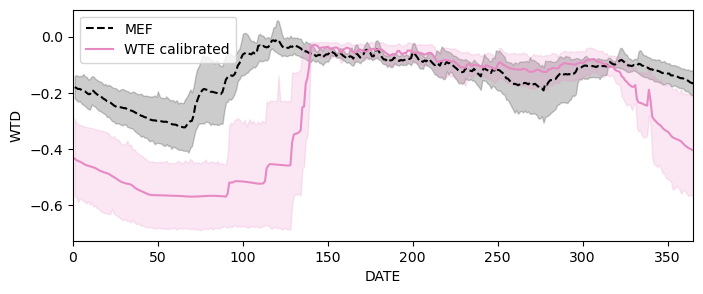

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (8,3))
sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF', ax = ax)
sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = -np.array(wteCalib.isel(column = 1).ZWT).reshape(2190),
             label = 'WTE calibrated', color = pal[3], ax = ax)
ax.set_xlim(0,365)

(0.0, 365.0)

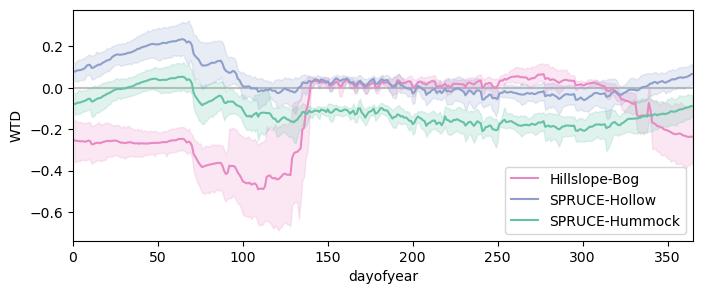

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (8,3))

hillslopeDiff = -np.array(wteCalib.isel(column = 1).ZWT).reshape(2190) - obsWTE
hollowDiff = -SPRUCEcalib.sel(lndgrid = 1).ZWT - obsWTE
hummockDiff = -SPRUCEcalib.sel(lndgrid = 0).ZWT - obsWTE
sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = hillslopeDiff,
             label = 'Hillslope-Bog', color = pal[3], ax = ax)
sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = hollowDiff,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax)
sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = hummockDiff,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax)
ax.axline([0,0], slope = 0, color = 'silver', zorder = -2)

ax.set_xlim(0, 365)

(0.0, 365.0)

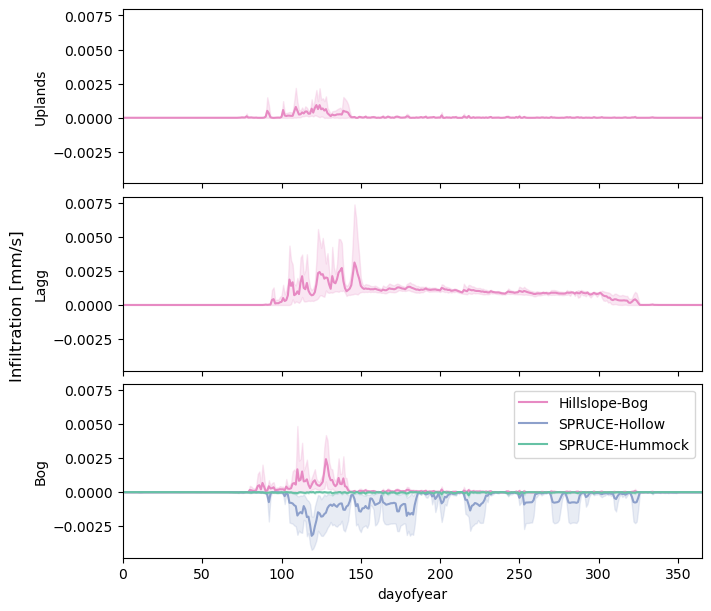

In [38]:
fig, ax = plt.subplots(3, 1, figsize = (7, 6), 
                      sharex = True, 
                      sharey = True, 
                      constrained_layout = True)

sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = np.array(wteCalib.isel(column = 2).QINFL).reshape(2190),
             color = pal[3], ax = ax[0])

sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = np.array(wteCalib.isel(column = 0).QINFL).reshape(2190),
             color = pal[3], ax = ax[1])

sns.lineplot(x = wteCalib.isel(column = 1).time.dt.dayofyear, y = np.array(wteCalib.isel(column = 1).QINFL).reshape(2190),
             label = 'Hillslope-Bog', color = pal[3], ax = ax[2])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).QINFL,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax[2])
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).QINFL,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax[2])

ax[0].set_ylabel('Uplands')
ax[1].set_ylabel('Lagg')
ax[2].set_ylabel('Bog')
fig.supylabel('Infiltration [mm/s]')
ax[2].set_xlim(0,365)